In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.insert(0, os.path.abspath("../../.."))


In [29]:
from dotenv import load_dotenv
from pathlib import Path
import pandas as pd
import numpy as np

# Database
from simpa.src.db import PostgresDB
from simpa.src.schemas import Proband
from simpa.src.cohorts import Cohort

# Clustering
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AffinityPropagation

# Clustering Evaluation
from sklearn.metrics import silhouette_score

# Plotting matrix
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
import umap.umap_ as umap

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from simpa.src.plotting import plot_endpoints_for_clusters

# snf
import snf

sns.color_palette()


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [4]:
load_dotenv()


True

In [5]:
PICKLE_PATH = "../scripts/TR1/"
# CLUSTERING
N_CLUSTERS = 20
N_COMPONENTS = 2


In [6]:
db = PostgresDB(
    db_name=os.getenv("DB_NAME"),
    host=os.getenv("DB_HOST"),
    port=os.getenv("DB_PORT"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
)


Connected to database


In [7]:
dfs = {}
for dir in Path(PICKLE_PATH).iterdir():
    name = dir.stem
    df = pd.read_pickle(dir)
    dfs[name] = df
df_arr_l = [v.to_numpy() for v in dfs.values()]

### With network fusion library

In [8]:
fn = snf.snf(df_arr_l, K=20)

KeyboardInterrupt: 

In [ ]:
df_fn = pd.DataFrame(fn)

In [ ]:
best, second = snf.get_n_clusters(fn)

RecursionError: maximum recursion depth exceeded while calling a Python object

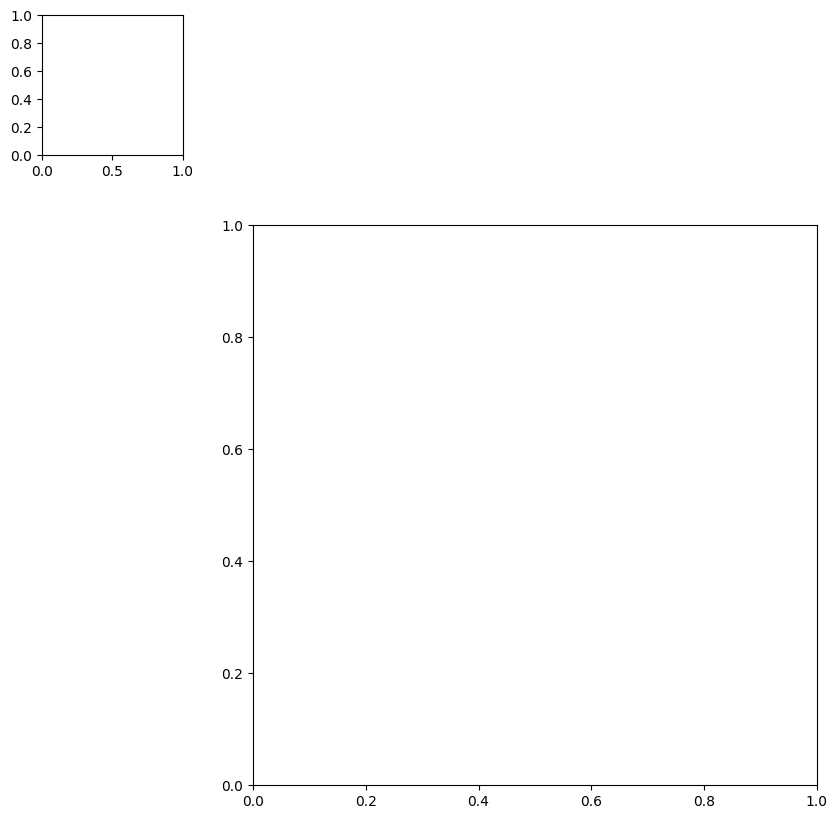

In [ ]:
sns.clustermap(df_fn, annot=False, xticklabels=False, yticklabels=False, fmt=".2f", cmap="Blues")

In [ ]:
spectral_cluster = SpectralClustering(
    n_clusters=N_CLUSTERS, affinity="precomputed", n_init=100
).fit(df_fn)

In [ ]:
affinity_cluster = AffinityPropagation().fit(df_fn)

In [ ]:
tsne = TSNE(n_components=N_COMPONENTS)
tsne_pos = tsne.fit_transform(df_fn)

/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


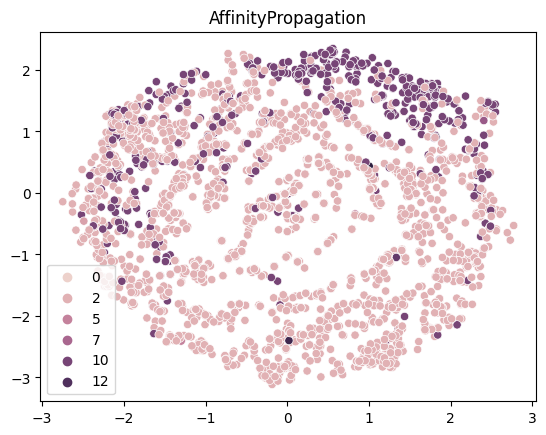

In [ ]:
sns.scatterplot(x=tsne_pos[:, 0], y=tsne_pos[:, 1], hue=affinity_cluster.labels_, cmap="").set_title(
    f"{affinity_cluster.__class__.__name__}"
)
plt.show()

### Weighted sum fusion

In [43]:
# SIMILARITY SCORE
DEMO_WEIGHT = 0.2
ICD_WEIGHT = 0.2
LAB_WEIGHT = 0.2
VITALS_WEIGHT = 0.2
INPUT_WEIGHT = 0.2
AGGREGATE = "mean"

N_CLUSTERS = 4


In [44]:
f_df = (
    dfs["demographics"] * DEMO_WEIGHT
    + dfs["icd"] * ICD_WEIGHT
    + dfs["lab"] * LAB_WEIGHT
    + dfs["vital"] * VITALS_WEIGHT
    + dfs["input"] * INPUT_WEIGHT
)


In [45]:
kmeans_cluster = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(f_df)
spectral_cluster = SpectralClustering(
    n_clusters=N_CLUSTERS, affinity="precomputed", n_init=100
).fit(f_df)
affinity_cluster = AffinityPropagation().fit(f_df)

/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [46]:
silhouette_kmeans = silhouette_score(f_df, kmeans_cluster.labels_)
silhouette_spectral = silhouette_score(f_df, spectral_cluster.labels_)
silhouette_affinity = silhouette_score(f_df, affinity_cluster.labels_)

print(f"Silhouette Score for kmeans: {silhouette_kmeans}")
print(f"Silhouette Score for spectral: {silhouette_spectral}")
print(f"Silhouette Score for affinity: {silhouette_affinity}")

Silhouette Score for kmeans: 0.17180651487838938
Silhouette Score for spectral: 0.11269778992731042
Silhouette Score for affinity: 0.042259783343461754


In [28]:
print((f_df < 0).any().any())

False


<Axes: >

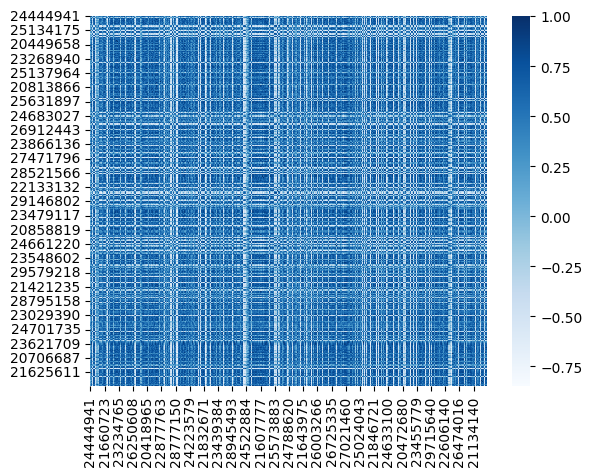

In [47]:
sns.heatmap(f_df.corr(), annot=False, cmap="Blues")